In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

In [2]:
print(tf.version.VERSION)

2.10.0


In [3]:
# Paths to datasets
train_dir = "efficientnet_dataset/train"
val_dir = "efficientnet_dataset/val"
test_dir = "efficientnet_dataset/test"

# Parameters
image_size = (224, 224)
batch_size = 16
epochs = 30
learning_rate = 0.001


In [4]:
# Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 367 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [5]:
# Load the EfficientNetV2B0 model pre-trained on ImageNet, excluding the top layer
base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

In [6]:
# Load EfficientNetV2B0 with pre-trained weights
base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


In [7]:
# Add Custom Layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


In [8]:
from tensorflow.keras.optimizers import Adam

# Compile Model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size,
)

Epoch 1/30
22/22 [==============================] - 204s 9s/step - loss: 0.1427 - accuracy: 0.9487 - val_loss: 2.2822e-05 - val_accuracy: 1.0000
Epoch 2/30
22/22 [==============================] - 192s 9s/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 1.7545e-04 - val_accuracy: 1.0000
Epoch 3/30
22/22 [==============================] - 172s 8s/step - loss: 0.0112 - accuracy: 0.9972 - val_loss: 1.7130e-05 - val_accuracy: 1.0000
Epoch 4/30
22/22 [==============================] - 145s 7s/step - loss: 0.0351 - accuracy: 0.9886 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 5/30
22/22 [==============================] - 142s 6s/step - loss: 0.0507 - accuracy: 0.9801 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/30
22/22 [==============================] - 155s 7s/step - loss: 0.0366 - accuracy: 0.9858 - val_loss: 7.9208e-05 - val_accuracy: 1.0000
Epoch 7/30
22/22 [==============================] - 275s 13s/step - loss: 0.0218 - accuracy: 0.9943 - val_loss: 0.0025 - val_accuracy: 1.0

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

7/7 [==============================] - 61s 8s/step - loss: 6.7467e-05 - accuracy: 1.0000
Test Loss: 0.0001, Test Accuracy: 1.0000


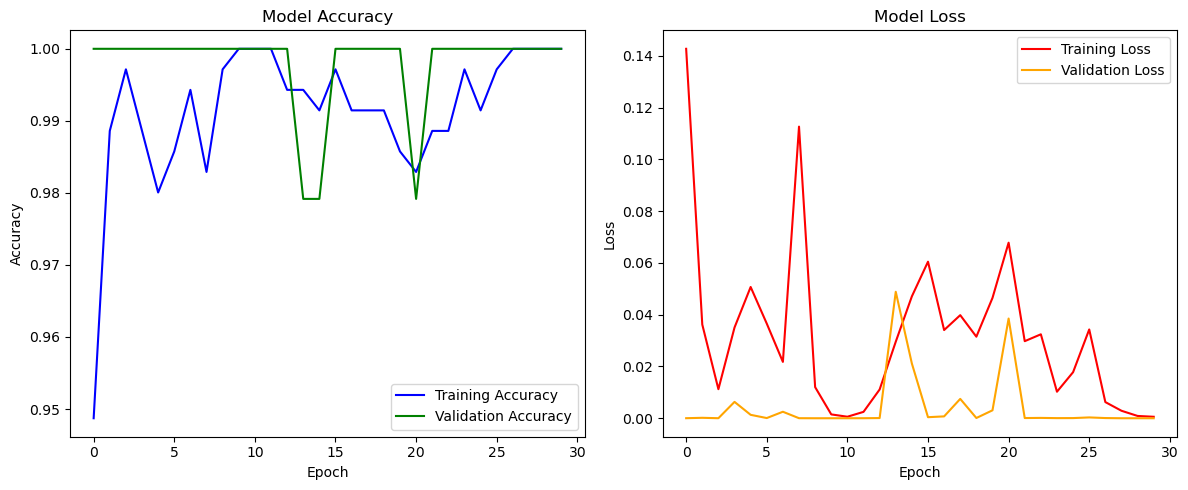

In [11]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Show plots
    plt.tight_layout()
    plt.show()

# Call the function to display the plots for the initial training
plot_training_history(history)




In [37]:
import os
import time

image_path = os.path.join('efficientnet_dataset', 'test', 'fruit', '20240713_151929.jpg')

print(image_path)

efficientnet_dataset\test\fruit\20240713_151929.jpg


In [71]:
def predict_image(image_path, model, class_indices, threshold=0.9):
    import time
    from tensorflow.keras.preprocessing import image
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.applications.efficientnet import preprocess_input

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = preprocess_input(img_array)

    # Measure inference time
    start_time = time.time()
    predictions = model.predict(img_array)
    end_time = time.time()

    inference_time = end_time - start_time  # In seconds

    # Get the prediction details
    predicted_confidence = np.max(predictions[0])  # Highest probability
    predicted_class = np.argmax(predictions[0])  # Index of the highest probability

    # Map class indices to class names
    class_names = {v: k for k, v in class_indices.items()}

    # Check confidence threshold
    if predicted_confidence < threshold:
        return "Unrecognized", predicted_confidence, inference_time
    else:
        return class_names[predicted_class], predicted_confidence, inference_time


# Path to an unrelated/wrong image
image_path = os.path.join('efficientnet_dataset', 'test', 'fruit', '105192155.jpg')
class_indices = train_generator.class_indices

# Predict with threshold
predicted_class, confidence, inference_time = predict_image(image_path, model, class_indices, threshold=0.8)
print(f'Predicted label: {predicted_class}\nConfidence: {confidence:.2f}\nInference time: {inference_time:.4f} seconds')


1/1 [==============================] - 0s 33ms/step
Predicted label: fruit
Confidence: 1.00
Inference time: 0.0714 seconds


In [42]:
model.save('./efficientNet_model/efficient_classify_model.h5')